In [1]:
import tensorflow as tf
import numpy as np
import keras.layers as kl
import keras.losses as loss
from keras import Sequential
import keras.optimizers as ko
import pandas as pd
import matplotlib.pyplot as plt

2023-06-17 03:26:37.952277: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-17 03:26:37.971864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    dice_coef = numerator / (denominator + tf.keras.backend.epsilon())
    return 1 - dice_coef

In [3]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Calculate the binary cross-entropy
    cross_entropy = tf.keras.backend.binary_crossentropy(y_true, y_pred, from_logits=False)

    # Calculate the focal weights
    pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    focal_weights = alpha_factor * tf.pow(1 - pt, gamma)

    # Apply the focal weights to the cross-entropy loss
    focal_loss = focal_weights * cross_entropy

    # Compute the mean loss across all samples
    return tf.reduce_mean(focal_loss)

In [4]:
X = tf.reshape(tf.constant(np.linspace(0,1,100_000*16*16)), (100_000,16,16,1))
Y = tf.reshape(tf.constant(np.linspace(0,1,1000)), (1000,1))

In [25]:
# Define the encoder model
encoder_model = tf.keras.models.Sequential()
encoder_model.add(tf.keras.layers.Conv2D(40, (2, 2), activation='relu', padding='same', input_shape=X.shape[1:]))
encoder_model.add(tf.keras.layers.Conv2D(20, (2, 2), activation='relu', padding='same'))
encoder_model.add(tf.keras.layers.Conv2D(20, (2, 2), activation='relu', padding='same'))
encoder_model.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))
encoder_model.add(kl.BatchNormalization())
encoder_model.add(tf.keras.layers.Conv2D(20, (2, 2), activation='relu', padding='same'))
encoder_model.add(tf.keras.layers.Conv2D(20, (2, 2), activation='relu', padding='same'))
encoder_model.add(tf.keras.layers.Conv2D(20, (2, 2), activation='relu', padding='same'))
encoder_model.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))
encoder_model.add(kl.BatchNormalization())
encoder_model.add(tf.keras.layers.Conv2D(20, (2, 2), activation='relu', padding='same'))
encoder_model.add(tf.keras.layers.Conv2D(20, (2, 2), activation='relu', padding='same'))
encoder_model.add(tf.keras.layers.Conv2D(20, (2, 2), activation='relu', padding='same'))
encoder_model.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))

# Define the decoder model
decoder_model = tf.keras.models.Sequential()
decoder_model.add(tf.keras.layers.Conv2D(40, (2, 2), activation='relu', padding='same'))
decoder_model.add(tf.keras.layers.Conv2D(40, (2, 2), activation='relu', padding='same'))
decoder_model.add(tf.keras.layers.Conv2D(40, (2, 2), activation='relu', padding='same'))
decoder_model.add(tf.keras.layers.UpSampling2D((2, 2)))
encoder_model.add(kl.BatchNormalization())
decoder_model.add(tf.keras.layers.Conv2D(40, (2, 2), activation='relu', padding='same'))
decoder_model.add(tf.keras.layers.Conv2D(40, (2, 2), activation='relu', padding='same'))
decoder_model.add(tf.keras.layers.Conv2D(40, (2, 2), activation='relu', padding='same'))
decoder_model.add(tf.keras.layers.UpSampling2D((2, 2)))
encoder_model.add(kl.BatchNormalization())
decoder_model.add(tf.keras.layers.Conv2D(40, (2, 2), activation='relu', padding='same'))
decoder_model.add(tf.keras.layers.Conv2D(40, (2, 2), activation='relu', padding='same'))
decoder_model.add(tf.keras.layers.Conv2D(40, (2, 2), activation='relu', padding='same'))
decoder_model.add(tf.keras.layers.UpSampling2D((2, 2)))
decoder_model.add(tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'))


# Combine the encoder and decoder into an autoencoder model
autoencoder_model = tf.keras.models.Sequential([encoder_model, decoder_model])

# Compile the autoencoder model
autoencoder_model.compile(optimizer=ko.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['mae'])

# Print the summary of the autoencoder model
# autoencoder_model.summary()
encoder_model.summary()
decoder_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 16, 16, 40)        200       
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 20)        3220      
                                                                 
 conv2d_54 (Conv2D)          (None, 16, 16, 20)        1620      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 20)         0         
 2D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 20)         80        
 chNormalization)                                                
                                                                 
 conv2d_55 (Conv2D)          (None, 8, 8, 20)         

In [26]:
hist = autoencoder_model.fit(X, X, epochs=5, batch_size=100)

Epoch 1/5


1000/1000 [==============================] - 12s 11ms/step - loss: 0.6435 - mae: 0.1974
Epoch 2/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.5416 - mae: 0.0790
Epoch 3/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.5199 - mae: 0.0486
Epoch 4/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.5113 - mae: 0.0352
Epoch 5/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.5062 - mae: 0.0246


In [27]:
dfm = pd.DataFrame(hist.history)

<Axes: >

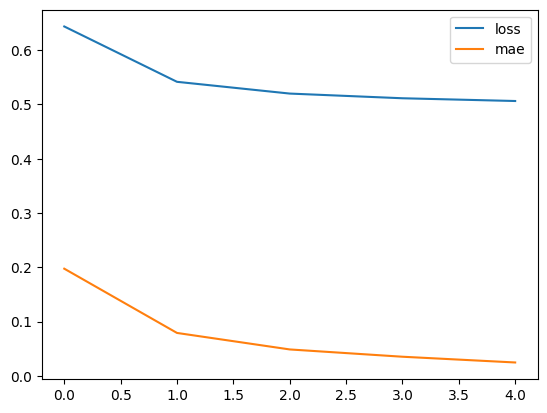

In [28]:
dfm.plot()

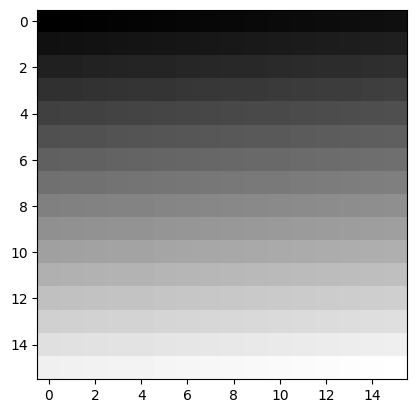

In [29]:
plt.imshow(X[0], cmap='gray')

In [30]:
pred = autoencoder_model.predict(X[0:1])

1/1 [==============================] - 0s 99ms/step


In [31]:
np.unique(pred)

array([0.00551485, 0.00640916, 0.00650483, 0.0070918 , 0.00788281,
       0.00792633, 0.00895665, 0.00920897, 0.0096335 , 0.00963543,
       0.00966801, 0.0098544 , 0.01014373, 0.01016997, 0.01025008,
       0.01037966, 0.01039109, 0.01065709, 0.01074502, 0.01120445,
       0.01147157, 0.01156791, 0.01182889, 0.01223457, 0.0122672 ,
       0.01230383, 0.01252133, 0.01258001, 0.01322165, 0.01462453,
       0.01476245, 0.014764  , 0.01476449, 0.01477982, 0.01526383,
       0.01559514, 0.01574388, 0.01602703, 0.01700477, 0.01705299,
       0.01739627, 0.01843995, 0.01847886, 0.01921304, 0.02033251,
       0.0220112 , 0.02209138, 0.02221338, 0.02492776, 0.02683138,
       0.02691627, 0.02705199, 0.02764597, 0.0282116 , 0.02972933,
       0.03118831, 0.03851767, 0.03871772, 0.05011861, 0.07608015,
       0.08557189, 0.16568206, 0.19468229, 0.36673862], dtype=float32)

In [32]:
npred = np.reshape(pred[0], (16,16))

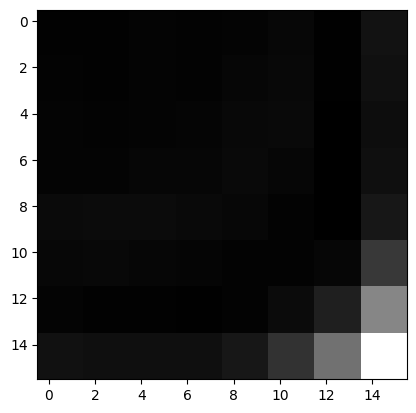

In [33]:
plt.imshow(pred[0], cmap='gray')